In [1]:
import pandas as pd
import torch
import statsmodels.formula.api as smf
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt

## Read in the data and display rows
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df.head(4)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890


In [2]:
# Choose a country ('US')
country = 'US'
df_country = df[df['Country/Region'] == country]

df_country = df_country.drop(columns=['Lat', 'Long'])

# Sum cases across different provinces/states for the US
df_country = df_country.sum(numeric_only=True, axis=0)

# Convert the series to a DataFrame and reset the index
df_country = pd.DataFrame(df_country).reset_index()
df_country.columns = ['Date', 'Cases']

# Convert from Cumulative to Daily Cases
covid_data_daily = df_country['Cases'].diff()
df_country['Daily'] = covid_data_daily

# Reset the index to represent days since the outbreak onset (t=0)
df_country = df_country.reset_index(drop=True)

# Create lagged variables (up to 5 days) -- note the lagged case variables refer to daily case counts
for i in range(1, 6):
    df_country[f'Cases_lag{i}'] = df_country['Daily'].shift(i)

# Convert from Cumulative to Daily Cases
covid_data_daily = df_country['Cases'].diff()
df_country['Daily'] = covid_data_daily

# Reset the index to represent days since the outbreak onset (t=0)
df_country = df_country.reset_index(drop=True)

# Create lagged variables (up to 5 days) -- note the lagged case variables refer to daily case counts
for i in range(1, 6):
    df_country[f'Cases_lag{i}'] = df_country['Daily'].shift(i)

# Drop rows with NaN values caused by lagging
df_country = df_country.dropna()
df_country.head()

# Define dependent and independent variables
y = df_country['Daily']
X = df_country[['Cases_lag1', 'Cases_lag2', 'Cases_lag3', 'Cases_lag4', 'Cases_lag5']]

df_country.head(5)

,Date,Cases,Daily,Cases_lag1,Cases_lag2,Cases_lag3,Cases_lag4,Cases_lag5
6,1/28/20,5,0.0,0.0,3.0,0.0,1.0,0.0
7,1/29/20,6,1.0,0.0,0.0,3.0,0.0,1.0
8,1/30/20,6,0.0,1.0,0.0,0.0,3.0,0.0
9,1/31/20,8,2.0,0.0,1.0,0.0,0.0,3.0
10,2/1/20,8,0.0,2.0,0.0,1.0,0.0,0.0


In [ ]:
# Get and Format Training Data
xtraining = torch.from_numpy(df_country.iloc[:,3:].astype(float).to_numpy())
ytraining = torch.from_numpy(df_country['Daily'].astype(float).to_numpy())

xtraining = xtraining.float()
ytraining = ytraining.float()

ytraining = ytraining.unsqueeze(1)

ytraining

In [33]:
model = torch.nn.Sequential(
    torch.nn.Linear(5, 2),  # 5 inputs to 2 nodes
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1)   # 2 nodes one output
)

## MSE is the loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

## Set the optimizer
## There are lots of choices
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

## Loop over iterations
for t in range(10000):

    ## Forward propagation
  y_pred = model(xtraining)
    
  ## the loss for this interation
  loss = loss_fn(y_pred, ytraining)

  ## Zero out the gradients before adding them up 
  optimizer.zero_grad()
  
  ## Backprop
  loss.backward()
  
  ## Optimization step
  optimizer.step()

In [34]:
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

0.weight: tensor([[-8.6066e+24, -8.5953e+24, -8.7977e+24, -9.5048e+24, -9.5064e+24],
        [-5.7660e+07, -6.1534e+07, -1.3467e+08, -1.4359e+08, -1.8697e+08]])
0.bias: tensor([-3.7928e+19, -7.3540e+02])
2.weight: tensor([[-4.6560e+26,  6.1281e+07]])
2.bias: tensor([91295.2344])


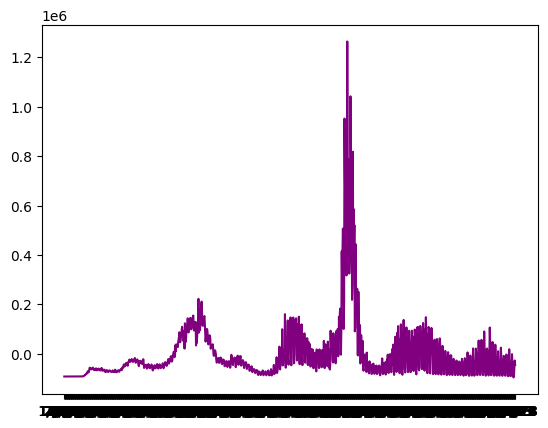

In [44]:
ypred = model(xtraining).detach().numpy().reshape(-1)
mse =  ytraining.numpy().reshape(-1) - ypred

plt.plot(df_country['Date'], mse, label='Standardized Prediction Error (1 hidden layer, two nodes)',color='purple')
